In [16]:
import datetime as dt
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns; 
plt.style.use('seaborn-whitegrid')

import sys

sys.path.append('/Users/annasintsova/git_repos/HUTI-RNAseq/code/methods')
import keggAPI
import helpers

import itertools

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import numpy as np
from operator import itemgetter
import os
import pandas as pd
import scipy as ss
import scipy.stats
from sklearn.decomposition import PCA
import seaborn as sns; sns.set_style("ticks")





today = dt.datetime.today().strftime("%Y-%m-%d")
def sample_label(strain, treat, join = " | "):
    return strain+join+treat

col1 = "#f34236"
col2 = "#d6c571"
col3 = "#88bc67"
col4 = "#2e8174"
col5 = "#143969"
colors = [col1, col2, col3, col4, col5]
ur = "URINE"
uti = "PATIENT"
join = " | "


stat = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/other_rnaseq/reads/bam_alignment_stats.csv"
 
info = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/other_rnaseq/SraRunTable.txt"        
out_dir = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/meta_analysis"
figures_folder = "/Users/annasintsova/git_repos/HUTI-RNAseq/figures/resource_reallocation/"



In [2]:
rRNA_genes = keggAPI.searchKEGGGenome("eco", "ribosomal RNA", out_dir)
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-16_eco_ribosomal_subunit.kegg.results", "r") as fh:
    ribosome_genes = [line.split()[0].rstrip().split(":")[1].strip() for line in fh]
    
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-13_crp_activator_info.tab", "r") as fh:
    crp_genes = [line.split()[0].rstrip() for line in fh]
print(len(rRNA_genes), len(ribosome_genes), len(crp_genes))

22 57 421


In [3]:
def find_files_in_a_tree(folder, file_type='fastq'):
    f_files = []
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            if name.endswith(file_type):
                f_files.append(os.path.join(root, name))
    return f_files

In [4]:
info_df = pd.read_csv(info, sep = "\t", index_col = 5 )
to_keep = ["Sample_Name", "sample_type", "isolate"]
info_table = info_df[to_keep]
info_table = info_table[~info_table.Sample_Name.str.contains("double")]

# also not going to look at control samples 

info_table =  info_table[info_table.sample_type == "treatment"]
info_table
#info_table.to_csv(os.path.join(out_dir, "2018-07-17-info-table.csv"))


,Sample_Name,sample_type,isolate
Run,,,
SRR1051491,UTI1,treatment,single sample from UTI patient 1
SRR1051500,UTI2,treatment,single sample from UTI patient 2
SRR1051501,UTI3,treatment,single sample from UTI patient 3
SRR1051511,UTIU3,treatment,UTIU3 sample 1 from patient U3
SRR1051502,UTI4,treatment,single sample from UTI patient 4
SRR1051503,UTI5,treatment,single sample from UTI patient 5
SRR1051515,UTIU5,treatment,UTIU5 sample 1 from patient U5
SRR1051504,UTI8,treatment,single sample from UTI patient 8
SRR1051507,UTI9,treatment,single sample from UTI patient 9


In [8]:
# Unfiltered counts
counts_dir = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/other_rnaseq/reads/"
files = find_files_in_a_tree(counts_dir, "st.csv")
print(len(files))
df_list = [pd.read_csv(f, index_col=0, header=None, 
            names = [os.path.basename(f).split("_")[0]]) for f in files]
new_df_list=[]
for d in df_list:
    nd = d.groupby(d.index).agg(sum)
    new_df_list.append(nd)
    
df = pd.concat(new_df_list, axis=1)

print(df.loc[:, ["SRR1051488",  "SRR1051514"]].head())

df_treat = (df[info_table.index]
            .drop(rRNA_genes, axis=0))
print(df.shape[0] - df_treat.shape[0] == 22)
print(df_treat.loc[:,["SRR1051488",  "SRR1051485"]].head())
total_reads = df_treat.sum(axis=0)
print(len(total_reads) == 21)

ribosome_counts = df_treat.loc[ribosome_genes].sum(axis=0)
ribosome_counts
print(len(ribosome_counts) == 21)
crp_genes_edited = [c for c in crp_genes if c in df_treat.index]
print("Missing {} crp genes".format(len(crp_genes) - len(crp_genes_edited)))
crp_counts = df_treat.loc[crp_genes_edited].sum(axis=0)
print(len(crp_counts) == 21)

totals =  pd.DataFrame({'Total': total_reads,'R':ribosome_counts,
                        'C': crp_counts})
totals["C%"] = round(totals["C"]/totals["Total"]*100,2)
totals["R%"] = round(totals["R"]/totals["Total"]*100,2)
#totals['condition'] = [c.split("_")[1] for c in totals.index]
totals

31
       SRR1051488  SRR1051514
b0001           9           8
b0002        2574          88
b0003         953          61
b0004         871          38
b0005          27           4
True
       SRR1051488  SRR1051485
b0001           9           1
b0002        2574         156
b0003         953         114
b0004         871         131
b0005          27           9
True
True
Missing 5 crp genes
True


,Total,R,C,C%,R%
SRR1051491,1216577,37528,157652,12.96,3.08
SRR1051500,1654147,324645,279599,16.90,19.63
SRR1051501,975331,129553,137811,14.13,13.28
SRR1051511,1951861,483494,277941,14.24,24.77
SRR1051502,1732469,66077,358084,20.67,3.81
SRR1051503,2080507,348910,397425,19.10,16.77
SRR1051515,370865,76072,46873,12.64,20.51
SRR1051504,1378999,353999,196523,14.25,25.67
SRR1051507,1078561,95900,211007,19.56,8.89
SRR1051490,620623,157198,84145,13.56,25.33


In [9]:
df_treat.to_csv(os.path.join(out_dir, "2018-07-19-combined-counts.csv"))
print(len(df_treat.index))
print(len(df_treat.index.unique()))

4476
4476


/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


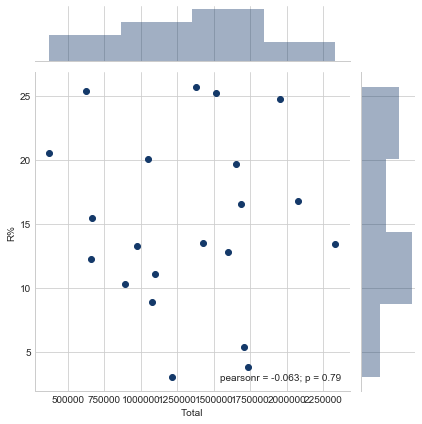

In [35]:
sns.jointplot(totals["Total"], totals["R%"], color= col5)

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


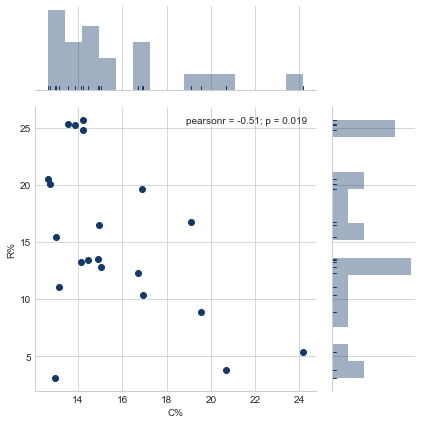

In [10]:
sns.jointplot(totals["C%"], totals["R%"], color= col5, marginal_kws=dict(bins=15, rug=True),ratio=3)

In [116]:
huti_df = pd.read_csv("/Users/annasintsova/git_repos/HUTI-RNAseq/results/"\
                      "resource_allocation/2018-07-18-%-allocated.csv", index_col=0)
huti_df_uti = huti_df[huti_df.condition == "UTI"]
huti_df_ur = huti_df[huti_df.condition == "UR"]

Text(0,0.5,'% r-protein gene expression')

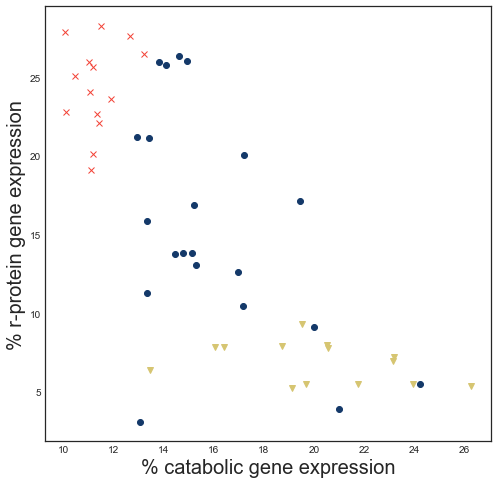

In [131]:
sns.set_style("white")
sns.set_context(font_scale=1.1)
fig = plt.figure(figsize=(8,8))

plt.plot(totals["C%"], totals["R%"], "o", color= col5)
plt.plot(huti_df_uti["C%"], huti_df_uti["R%"], "x", color=col1)
plt.plot(huti_df_ur["C%"], huti_df_ur["R%"], "v", color=col2)
plt.xlabel("% catabolic gene expression", fontsize=20)
plt.ylabel("% r-protein gene expression", fontsize=20)


In [135]:
together = pd.concat([totals, huti_df_uti], sort=False)
together

,Total,R,C,C%,R%,condition
SRR1051491,1197684.0,37402.0,156450.0,13.06,3.12,NaN
SRR1051500,1609974.0,322737.0,276690.0,17.19,20.05,NaN
SRR1051501,937913.0,129029.0,135569.0,14.45,13.76,NaN
SRR1051511,1832724.0,477376.0,273606.0,14.93,26.05,NaN
SRR1051502,1694095.0,65899.0,355676.0,21.00,3.89,NaN
SRR1051503,2032174.0,347993.0,395032.0,19.44,17.12,NaN
SRR1051515,354777.0,75267.0,45841.0,12.92,21.22,NaN
SRR1051504,1337494.0,352978.0,195328.0,14.60,26.39,NaN
SRR1051507,1042419.0,95206.0,208386.0,19.99,9.13,NaN
SRR1051490,602580.0,156431.0,83116.0,13.79,25.96,NaN


/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


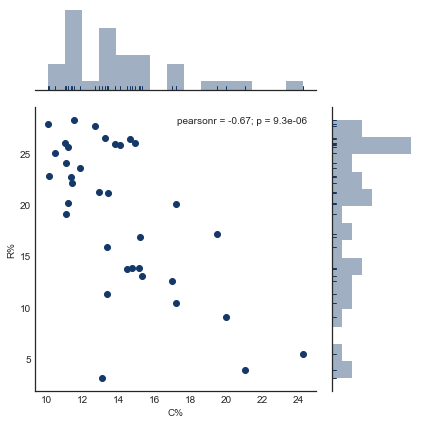

In [136]:
sns.jointplot(together["C%"], together["R%"], color= col5, marginal_kws=dict(bins=15, rug=True),ratio=3)

In [86]:
# Filtered counts : No difference, looks like counting already takes this into account lol
counts_dir = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/other_rnaseq/reads/filtered_bam/"
files = find_files_in_a_tree(counts_dir, "bam.counts")
print(len(files))
df_list = []
for f in files:
    df = pd.read_table(f, header=None).loc[:,[8,9]]
    df.columns = ["name", os.path.basename(f).split("_")[0]]
    df = df[df.name.str.contains("locus_tag")].set_index("name")
    df.index = [i.split("locus_tag=")[1] for i in df.index]
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)
print(df.loc[:, ["SRR1051488",  "SRR1051514"]].head())
df_treat = (df[info_table.index]
            .drop(rRNA_genes, axis=0))
print(df.shape[0] - df_treat.shape[0] == 22)
print(df_treat.loc[:,["SRR1051488",  "SRR1051485"]].head())
total_reads = df_treat.sum(axis=0)
print(len(total_reads) == 21)

ribosome_counts = df_treat.loc[ribosome_genes].sum(axis=0)
ribosome_counts
print(len(ribosome_counts) == 21)
crp_genes_edited = [c for c in crp_genes if c in df_treat.index]
print("Missing {} crp genes".format(len(crp_genes) - len(crp_genes_edited)))
crp_counts = df_treat.loc[crp_genes_edited].sum(axis=0)
print(len(crp_counts) == 21)

totals =  pd.DataFrame({'Total': total_reads,'R':ribosome_counts,
                        'C': crp_counts})
totals["C%"] = round(totals["C"]/totals["Total"]*100,2)
totals["R%"] = round(totals["R"]/totals["Total"]*100,2)
#totals['condition'] = [c.split("_")[1] for c in totals.index]
totals

31
       SRR1051488  SRR1051514
b0001           9           8
b0002        2553          87
b0003         935          61
b0004         869          37
b0005          27           4
True
       SRR1051488  SRR1051485
b0001           9           1
b0002        2553         149
b0003         935         112
b0004         869         131
b0005          27           9
True
True
Missing 10 crp genes
True


,Total,R,C,C%,R%
SRR1051491,1197684,37402,156450,13.06,3.12
SRR1051500,1609974,322737,276690,17.19,20.05
SRR1051501,937913,129029,135569,14.45,13.76
SRR1051511,1832724,477376,273606,14.93,26.05
SRR1051502,1694095,65899,355676,21.00,3.89
SRR1051503,2032174,347993,395032,19.44,17.12
SRR1051515,354777,75267,45841,12.92,21.22
SRR1051504,1337494,352978,195328,14.60,26.39
SRR1051507,1042419,95206,208386,19.99,9.13
SRR1051490,602580,156431,83116,13.79,25.96


In [13]:
### PCA

norm_counts = pd.read_csv(os.path.join(out_dir, "2018-07-19-deseq_norm_counts.csv"), index_col=0)
norm_counts.head()

,SRR1051491,SRR1051500,SRR1051501,SRR1051511,SRR1051502,SRR1051503,SRR1051515,SRR1051504,SRR1051507,SRR1051490,...,SRR1051493,SRR1051496,SRR1051497,SRR1051498,SRR1051499,SRR1051485,SRR1051486,SRR1051487,SRR1051488,SRR1051489
b0001,13.346861,2.353160,4.334135,46.383090,17.170233,10.419824,26.285097,2.124624,13.177426,6.563007,...,15.092520,5.238355,6.953216,10.231774,6.940176,1.133853,23.498549,5.119979,8.309718,11.285583
b0002,113.448319,344.345801,164.697116,139.149271,183.149148,160.856031,328.563712,433.423320,1193.498337,190.327216,...,482.122157,240.964324,381.036230,1219.627479,415.253886,176.881079,9477.517605,1196.027063,2376.579297,599.748150
b0003,142.048735,167.074386,89.572116,132.905393,148.236342,139.365144,174.138767,190.153858,974.188311,120.321803,...,482.960630,167.627356,186.346186,846.508782,179.287890,129.259250,2864.058408,492.541967,879.906787,325.669694
b0004,143.002082,200.018631,93.906250,123.985568,136.789520,112.013107,180.710042,213.524724,993.013206,96.257442,...,201.652832,171.119592,137.673674,477.482794,134.176743,148.534752,3113.557705,520.189853,804.196025,339.373617
b0005,19.066944,0.000000,1.444712,6.243878,4.578729,3.256195,3.285637,8.498496,12.236182,2.187669,...,15.930993,15.715065,0.000000,23.192021,3.470088,10.204678,33.174422,12.287949,24.929153,8.867244


In [14]:
def findTwoComponents(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = pd.DataFrame(data=principalComponents
                       , columns=['PC1', 'PC2'])
    pDf.set_index(df.index, inplace=True)
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, c="", nameby="", title="", filename='',
            el=False):  # , xlimits, ylimits, labels): # colorby is column in pDf
    sns.set_style("ticks")
    group = pDf[colorby].unique()

    assert len(group) < 5
    if c:
        colrs = c
    else:
        colrs = colors[:len(group) + 1]

    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, colrs):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        # ax = plt.scatter(df.PC1, df.PC2, c= c, s = 150,label = g)
        plt.legend(fontsize=18, frameon=True)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, df.PC1, df.PC2):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",
                             fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), fontsize=15)
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if title:
            plt.title('2 component PCA', fontsize=20)
    if filename:
        fig.savefig(filename, dpi=300)
    return fig



def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


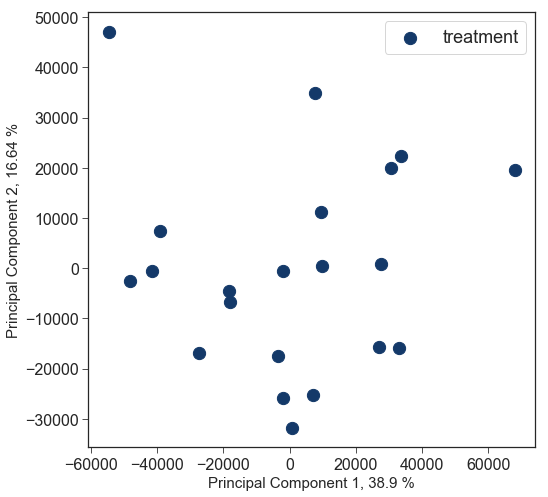

In [21]:
pDf, pc1, pc2 = findTwoComponents(norm_counts, info_table)
pDf
f = plotPCA(pDf, pc1, pc2, "sample_type", c=[col5, col1], nameby="", title="", filename='', el=False)

# ax = f.gca()
# ax.set_xlim((-25, 25))
# ax.set_ylim((-25, 25))
# fn = os.path.join(figures_folder, today+"_figure_2c.png")
# f.savefig(fn, dpi = 500, bbox_inches="tight")

In [44]:
info_table.drop(["SRR1051485"], axis=0, inplace=True)
df2 = df.T.loc[info_table.index]
# print(info_table.index)
# print(df.columns)
# for a in info_table.index:
#     if a not in df.columns:
#         print(a) Missing UTI10 sample

df3 = df2.merge(info_table, left_index=True, right_index=True)
df3.set_index("name", inplace=True)
df3.drop(["Sample_Name", "sample_type", "isolate"], axis =1, inplace=True)# clumsy
df4 = df3.T
print(df4.shape)
df4.drop(genes, axis=0, inplace=True)
df4.head()

(4518, 18)


name,UTI1_treatment,UTI2_treatment,UTI3_treatment,UTI4_treatment,UTI5_treatment,UTI8_treatment,UTI9_treatment,UTI19_treatment,UTI21_treatment,UTI23_treatment,UTI24_treatment,UTI25_treatment,UTI26_treatment,UTI27_treatment,UTI11_treatment,UTI14_treatment,UTI15_treatment,UTI17_treatment
b0001,15,3,3,30,16,2,14,3,2,36,3,10,15,6,34,5,9,14
b0002,122,439,115,327,251,409,1270,87,156,1158,141,549,1788,359,13713,1168,2576,745
b0003,150,218,62,260,215,180,1037,56,112,1156,98,269,1242,156,4145,481,953,406
b0004,153,257,70,239,174,202,1055,45,120,488,101,199,700,118,4515,508,871,422
b0005,23,7,4,15,9,11,13,2,19,112,12,7,41,7,51,17,33,13


In [26]:
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-16_eco_ribosomal_subunit.kegg.results", "r") as fh:
    ribosome_genes = [line.split()[0].rstrip().split(":")[1].strip() for line in fh]
    
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-13_crp_activator_info.tab", "r") as fh:
    crp_genes = [line.split()[0].rstrip() for line in fh]
ribosome_genes

['b0023',
 'b0169',
 'b0911',
 'b1089',
 'b1716',
 'b1717',
 'b2185',
 'b2597',
 'b2606',
 'b2609',
 'b3065',
 'b3165',
 'b3180',
 'b3185',
 'b3186',
 'b3230',
 'b3231',
 'b3259',
 'b3294',
 'b3296',
 'b3297',
 'b3298',
 'b3299',
 'b3301',
 'b3302',
 'b3303',
 'b3304',
 'b3305',
 'b3306',
 'b3307',
 'b3308',
 'b3309',
 'b3310',
 'b3311',
 'b3312',
 'b3313',
 'b3314',
 'b3315',
 'b3316',
 'b3317',
 'b3318',
 'b3319',
 'b3320',
 'b3321',
 'b3341',
 'b3342',
 'b3636',
 'b3637',
 'b3703',
 'b3936',
 'b3983',
 'b3984',
 'b3985',
 'b3986',
 'b4200',
 'b4202',
 'b4203']

In [27]:
def add_col_sum(df):
    df2 = df.T
    df2['col_sum'] = df.sum(axis=0)
    return df2.T
    

In [45]:
counts = df4.T
counts['total'] = df4.sum(axis=0) # All mapped reads
counts.tail()
counts = counts.T
counts.tail()

name,UTI1_treatment,UTI2_treatment,UTI3_treatment,UTI4_treatment,UTI5_treatment,UTI8_treatment,UTI9_treatment,UTI19_treatment,UTI21_treatment,UTI23_treatment,UTI24_treatment,UTI25_treatment,UTI26_treatment,UTI27_treatment,UTI11_treatment,UTI14_treatment,UTI15_treatment,UTI17_treatment
b4400,12,15,2,11,11,2,10,11,32,40,7,31,15,14,9,15,3,7
b4401,3475,1239,922,2817,1138,842,1465,255,393,1150,547,808,1180,706,1182,1577,1482,1229
b4402,563,127,54,501,175,125,215,37,70,215,90,90,166,67,231,170,309,209
b4403,46,40,38,105,44,65,91,17,18,89,21,48,49,19,119,43,34,50
total,1244940,1668760,985648,1773046,2105200,1391019,1095249,632210,677982,2400410,669546,1704359,1724163,1068075,1622085,1528726,1117241,1441569


In [46]:
ribosome_counts = counts.loc[ribosome_genes]
ribosome_counts = add_col_sum(ribosome_counts)
crp_counts = counts.loc[crp_genes]
crp_counts = add_col_sum(crp_counts)
crp_counts.tail()

/anaconda/envs/biology/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


name,UTI1_treatment,UTI2_treatment,UTI3_treatment,UTI4_treatment,UTI5_treatment,UTI8_treatment,UTI9_treatment,UTI19_treatment,UTI21_treatment,UTI23_treatment,UTI24_treatment,UTI25_treatment,UTI26_treatment,UTI27_treatment,UTI11_treatment,UTI14_treatment,UTI15_treatment,UTI17_treatment
b2943,1408.0,451.0,522.0,6623.0,3363.0,59.0,3184.0,62.0,108.0,146.0,278.0,330.0,654.0,112.0,90.0,153.0,112.0,372.0
b4233,202.0,433.0,286.0,400.0,451.0,462.0,300.0,158.0,137.0,919.0,172.0,568.0,355.0,299.0,383.0,504.0,276.0,414.0
b3260,416.0,3791.0,551.0,365.0,3356.0,2465.0,721.0,1560.0,1854.0,1766.0,1339.0,1754.0,295.0,2347.0,1366.0,4065.0,1608.0,1536.0
b0756,1035.0,235.0,258.0,1258.0,592.0,82.0,1013.0,77.0,63.0,296.0,500.0,409.0,1322.0,191.0,326.0,154.0,321.0,394.0
col_sum,159865.0,280900.0,138665.0,360919.0,399204.0,197490.0,212230.0,85186.0,87551.0,342707.0,110512.0,253252.0,413153.0,135550.0,242810.0,210890.0,146077.0,213294.0


In [47]:
totals =  pd.DataFrame({'Total': counts.loc["total"],'R':ribosome_counts.loc["col_sum"],
                        'C': crp_counts.loc["col_sum"]})
totals["C%"] = round(totals["C"]/totals["Total"]*100,2)
totals["R%"] = round(totals["R"]/totals["Total"]*100,2)
totals['condition'] = [c.split("_")[1] for c in totals.index]
totals

,Total,R,C,C%,R%,condition
name,,,,,,
UTI1_treatment,1244940,37909,159865.0,12.84,3.05,treatment
UTI2_treatment,1668760,324828,280900.0,16.83,19.47,treatment
UTI3_treatment,985648,129738,138665.0,14.07,13.16,treatment
UTI4_treatment,1773046,66694,360919.0,20.36,3.76,treatment
UTI5_treatment,2105200,349201,399204.0,18.96,16.59,treatment
UTI8_treatment,1391019,354237,197490.0,14.20,25.47,treatment
UTI9_treatment,1095249,96234,212230.0,19.38,8.79,treatment
UTI19_treatment,632210,157356,85186.0,13.47,24.89,treatment
UTI21_treatment,677982,103009,87551.0,12.91,15.19,treatment


/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


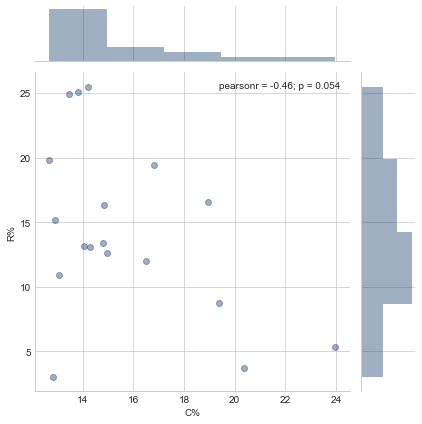

In [48]:
s = sns.jointplot(totals["C%"], totals["R%"], color= col5, alpha=0.4)

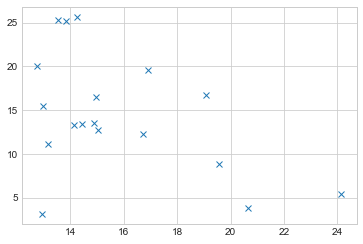

In [35]:
plt.plot(totals["C%"], totals["R%"], "x")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1136ada90>,
      dtype=object)

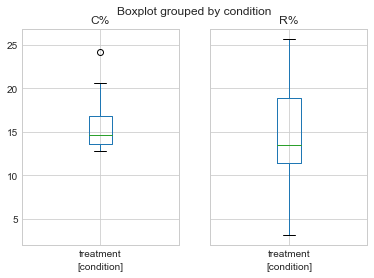

In [33]:
totals[["C%", "R%", "condition"]].boxplot(by = "condition")

In [16]:
flag = pd.read_csv(flagstat, index_col=0)
flag.index = [f.split("_trimmed")[0]+"_counts" for f in flag.index]
mapped = flag.loc[totals.index]['mapped']
totals['mapped'] = mapped
totals['core'] = round(totals["Total"]/totals['mapped']*100, 2)
totals

,C,R,Total,C%,R%,condition,mapped,core
HM01_UR_counts,2221907.0,452127.0,8455636.0,26.28,5.35,UR,16480326,51.31
HM01_UTI_counts,257224.0,608400.0,2339375.0,11.00,26.01,UTI,3717040,62.94
HM03_UR_counts,2553359.0,644395.0,11741588.0,21.75,5.49,UR,20927541,56.11
HM03_UTI_counts,640723.0,1399005.0,5060740.0,12.66,27.64,UTI,8059076,62.80
HM06_UR_counts,2480034.0,965260.0,12079025.0,20.53,7.99,UR,22847374,52.87
HM06_UTI_counts,296495.0,511732.0,2674526.0,11.09,19.13,UTI,4709092,56.79
HM07_UR_counts,2146501.0,587090.0,11231445.0,19.11,5.23,UR,20980473,53.53
HM07_UTI_counts,131125.0,254432.0,1149375.0,11.41,22.14,UTI,2097350,54.80
HM14_UR_counts,2779913.0,640552.0,11601756.0,23.96,5.52,UR,21533817,53.88
HM14_UTI_counts,1069506.0,2144423.0,8090208.0,13.22,26.51,UTI,12968218,62.38


In [17]:
catabolic_urine = pd.DataFrame({"sample":["CAT|UR"]*14, "% allocated":totals[totals["condition"] == "UR"]["C%"]})
cataboli_uti = pd.DataFrame({"sample":["CAT|UTI"]*14, "% allocated": totals[totals["condition"] == "UTI"]["C%"]})
ribosome_uti = pd.DataFrame({"sample":["RIB|UTI"]*14, "% allocated": totals[totals["condition"] == "UTI"]["R%"]})
ribosome_urine = pd.DataFrame({"sample":["RIB|UR"]*14, "% allocated": totals[totals["condition"] == "UR"]["R%"]})
core_urine = pd.DataFrame({"sample": ["CORE|UR"]*14, "% allocated":totals[totals["condition"] == "UR"]["core"]})
core_uti =pd.DataFrame({"sample": ["CORE|UTI"]*14, "% allocated":totals[totals["condition"] == "UTI"]["core"]})
final = pd.concat([cataboli_uti, catabolic_urine, ribosome_uti, ribosome_urine, core_urine, core_uti])
final.head()
catabolism = pd.concat([catabolic_urine, cataboli_uti])
ribosome = pd.concat([ribosome_urine, ribosome_uti])
core = pd.concat([core_urine, core_uti])

In [18]:
core

,% allocated,sample
HM01_UR_counts,51.31,CORE|UR
HM03_UR_counts,56.11,CORE|UR
HM06_UR_counts,52.87,CORE|UR
HM07_UR_counts,53.53,CORE|UR
HM14_UR_counts,53.88,CORE|UR
HM17_UR_counts,53.43,CORE|UR
HM43_UR_counts,57.23,CORE|UR
HM54_UR_counts,47.81,CORE|UR
HM56_UR_counts,56.19,CORE|UR
HM57_UR_counts,51.82,CORE|UR


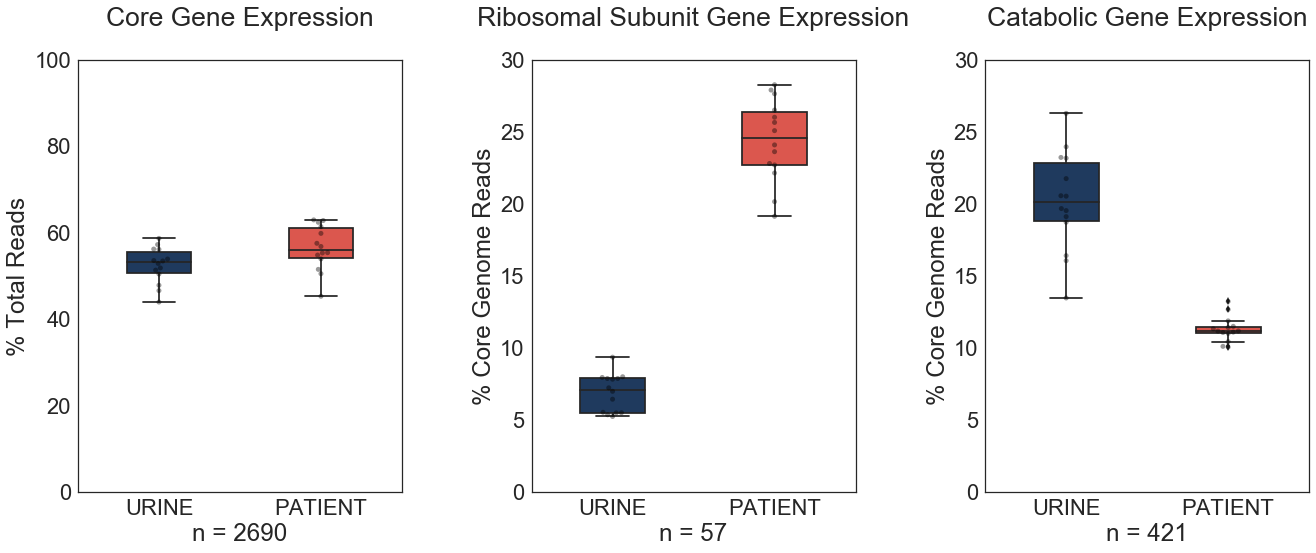

In [37]:
fig = plt.figure(figsize=(9,5))

sns.set(font_scale = 2.2)
sns.set_style("white")
# Catabolic Gene Expression
ax1 = fig.add_axes([0.1, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 100))
sns.boxplot(x = "sample", y = "% allocated", palette=[col5, col1],data = core,width=0.4)
sns.swarmplot(x = "sample", y = "% allocated", data = core, color = 'black', alpha = 0.4)
ax1.set_title("Core Gene Expression\n")
ax1.set_xticklabels([ur, uti])
ax1.set_xlabel("n = {}".format(counts3.shape[0]))
ax1.set_ylabel("% Total Reads")
# Ribosome Subunits Gene Expression

ax2 = fig.add_axes([0.8, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 30))
sns.boxplot(x = "sample", y = "% allocated",palette=[col5, col1], data = ribosome, width=0.4)
sns.swarmplot(x = "sample", y = "% allocated", data =ribosome, color = 'black', alpha = 0.4)
ax2.set_title("Ribosomal Subunit Gene Expression\n")
ax2.set_xticklabels([ur, uti])
ax2.set_xlabel("n = {}".format(len(ribosome_genes)))
ax2.set_ylabel("% Core Genome Reads")
# Core Gene Expression

ax3 = fig.add_axes([1.5, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 30))
sns.boxplot(x = "sample", y = "% allocated", palette=[col5, col1], data = catabolism, width=0.4)
sns.swarmplot(x = "sample", y = "% allocated", data =catabolism, color = 'black', alpha = 0.4)
ax3.set_title("Catabolic Gene Expression\n")
ax3.set_xticklabels([ur, uti])
ax3.set_xlabel("n = {}".format(len(crp_genes)))
ax3.set_ylabel("% Core Genome Reads")
fig.savefig(os.path.join(figures_folder, today+"_figure_4.png"),bbox_inches='tight',dpi=500 )

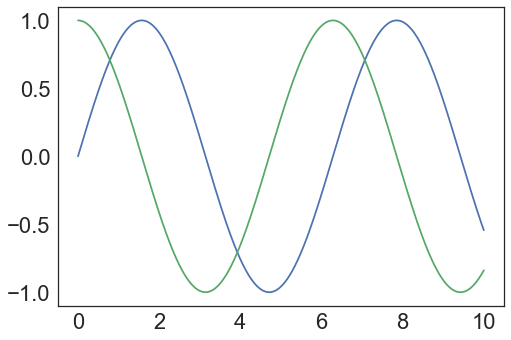

In [265]:
x = np.linspace(0, 10, 1000)
fig = plt.figure()
ax = plt.axes()
plt.plot(x, np.sin(x))
plt.plot(x, np.cos(x))

In [127]:
final1 = pd.DataFrame(totals["C%"])
final1['metabolism'] = ["C"]*28
final1.columns = ["% allocated", "metabolism"]
final1["condition"] = [c.split("_")[1] for c in final1.index]
final2 =pd.DataFrame(totals["R%"])
final2["metabolism"] = ["R"]*28
final2.columns = ["% allocated", "metabolism"]
final2["condition"] = [c.split("_")[1] for c in final2.index]
final3 = pd.DataFrame(totals["core"])
final3["metabolism"] = ["core"]*28
final3.columns = ["% allocated", "metabolism"]
final3["condition"] = [c.split("_")[1] for c in final3.index]
#final = pd.DataFrame(final, columns=[""])
#final["condition"] = [c.split("_")[1] for c in final.index]
final = pd.concat([final1, final2, final3])
final["condition"] = [c.split("_")[1] for c in final.index]
final

,% allocated,metabolism,condition
HM01_UR_counts,26.28,C,UR
HM01_UTI_counts,11.00,C,UTI
HM03_UR_counts,21.75,C,UR
HM03_UTI_counts,12.66,C,UTI
HM06_UR_counts,20.53,C,UR
HM06_UTI_counts,11.09,C,UTI
HM07_UR_counts,19.11,C,UR
HM07_UTI_counts,11.41,C,UTI
HM14_UR_counts,23.96,C,UR
HM14_UTI_counts,13.22,C,UTI


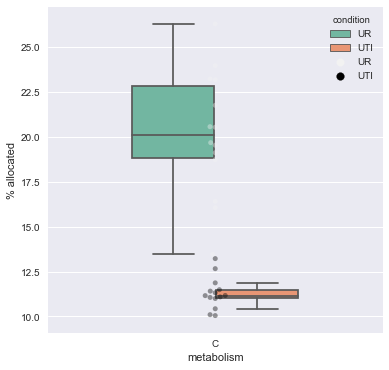

In [132]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(x = 'metabolism', y = "% allocated", data = final1, hue = "condition", palette="Set2", width=.5, showfliers=False)
ax = sns.swarmplot(x = "metabolism", y = "% allocated", data = final1, hue = 'condition',color = 'black', alpha = 0.4)

//anaconda/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


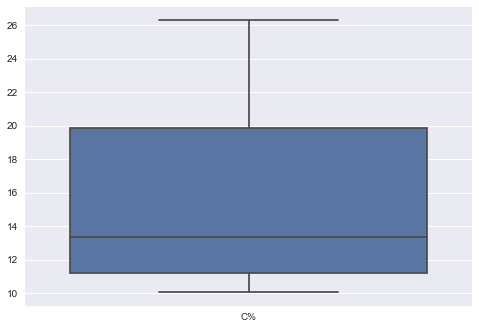

In [125]:
ax = sns.boxplot(totals[["C%", "condition"]])

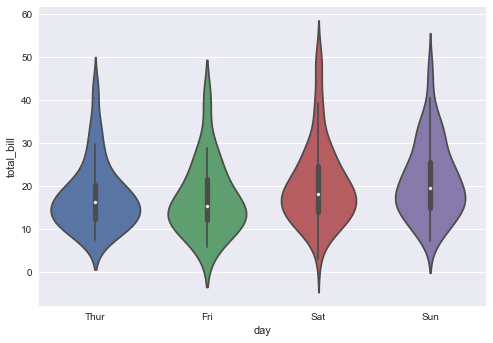

In [90]:
tips = sns.load_dataset("tips")
ax = sns.violinplot(x="day", y="total_bill", data=tips)

In [91]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
